State schems represents the structure and type of data that the graph will use

All nodes are expected to communicate with that schema

In [9]:
from typing_extensions import TypedDict, Literal


Typedict just uses type hints

##### Not enforced at runtime!!!

In [10]:
#States
class somestate(TypedDict):
    name: str
    game: Literal["chess", "monopoly", "soccer"]
    
#Nodes
def play_game(state:somestate):
    print("play_game node has been called")
    return {"name": state["name"] + " want to play "}
 
def chess(state:somestate):
    print("chess node has been called")
    return {"name": state["name"]+"chess","game": "chess", }

def monopoly(state:somestate):
    print("monopoly node has been called")
    return {"name": state["name"]+"monopoly", "game": "monopoly"}

def soccer(state:somestate):
    print("soccer node has been called")
    return {"name": state["name"]+"soccer", "game": "soccer"}

In [11]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

graph = StateGraph(somestate)
graph.add_node("play_game", play_game)
graph.add_node("chess", chess)
graph.add_node("monopoly", monopoly)
graph.add_node("soccer", soccer)    

In [12]:
def decide_play(state: somestate) -> Literal["chess", "monopoly", "soccer"]:
    
    if random.random() < 0.3:
        return "chess"
    elif random.random() < 0.6:
        return "monopoly"
    else:
        return "soccer"

Flow of the graph

In [13]:
graph.add_edge(START, "play_game")
graph.add_conditional_edges("play_game", decide_play)
graph.add_edge("chess", END)
graph.add_edge("monopoly", END)   
graph.add_edge("soccer", END) 


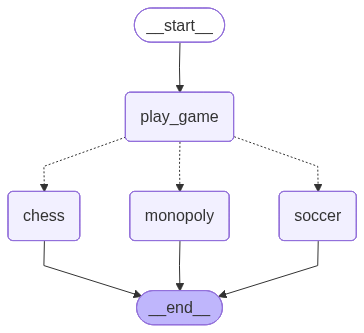

In [14]:
graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [15]:
graph_builder.invoke({'name': 'soham'})

play_game node has been called
soccer node has been called


{'name': 'soham want to play soccer', 'game': 'soccer'}

In [18]:
#Notice how typedict does not produce error for incorrect type

graph_builder.invoke({'name': 1234})  #This should ideally raise an error but it does not

play_game node has been called


TypeError: unsupported operand type(s) for +: 'int' and 'str'

Now we try DataClasses

Python dataclasses prvodies consise syntax for creatin classes primarily used to store data

In [19]:
#DataClasses

from dataclasses import dataclass

@dataclass
class diffState:
    name: 'str'
    game: Literal["chess", "monopoly", "soccer"]

notice differences in accessing name

In [20]:
#Nodes
def play_game(state:diffState):
    print("play_game node has been called")
    return {"name": state.name + " want to play "}
 
def chess(state:diffState):
    print("chess node has been called")
    return {"name": state.name+"chess","game": "chess", }

def monopoly(state:diffState):
    print("monopoly node has been called")
    return {"name": state.name+"monopoly", "game": "monopoly"}

def soccer(state:diffState):
    print("soccer node has been called")
    return {"name": state.name+"soccer", "game": "soccer"}

In [21]:
def decide_play(state: diffState) -> Literal["chess", "monopoly", "soccer"]:
    
    if random.random() < 0.3:
        return "chess"
    elif random.random() < 0.6:
        return "monopoly"
    else:
        return "soccer"

In [24]:
graph = StateGraph(diffState)
graph.add_node("play_game", play_game)
graph.add_node("chess", chess)
graph.add_node("monopoly", monopoly)
graph.add_node("soccer", soccer)   


In [25]:
graph.add_edge(START, "play_game")
graph.add_conditional_edges("play_game", decide_play)
graph.add_edge("chess", END)
graph.add_edge("monopoly", END)   
graph.add_edge("soccer", END) 
graph_builder = graph.compile()

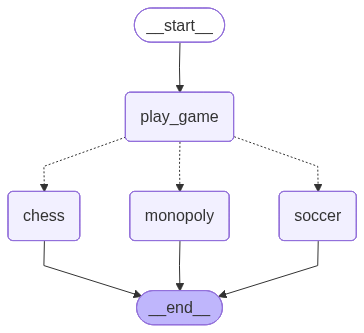

In [26]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

look at the difference in invoking

In [31]:
graph_builder.invoke(diffState(name='soham',
                       game='chess'))

play_game node has been called
monopoly node has been called


{'name': 'soham want to play monopoly', 'game': 'monopoly'}

In [32]:
#nothing is enforced at runtime

### Now look at pydantic

In [33]:
from pydantic import BaseModel, Field, ValidationError
from langgraph.graph import StateGraph, START, END


In [34]:
class State (BaseModel):
    name: str
    game: Literal["chess", "monopoly", "soccer"]

In [35]:
def play_game(state:State):
    print("play_game node has been called")
    return {"name": state.name + " want to play "}

In [49]:
def decide_play(state: somestate) -> Literal["chess", "monopoly", "soccer"]:
    
    if random.random() < 0.3:
        return "chess"
    elif random.random() < 0.6:
        return "monopoly"
    else:
        return "soccer"

In [50]:
# Nodes
def monopoly(state:State):
    return {"name": state.name + 'monopoly', "game": "monopoly"}

def soccer(state:State):
    return {"name": state.name + 'soccer', "game": "soccer"}

def chess(state:State):
    return {"name": state.name + 'chess', "game": "chess"}

In [51]:
#Build the graph
graph = StateGraph(State)
graph.add_node("play_game", play_game)
graph.add_node("chess", chess)
graph.add_node("monopoly", monopoly)
graph.add_node("soccer", soccer)


#Add the edges
graph.add_edge(START, "play_game")
graph.add_conditional_edges("play_game", decide_play)
graph.add_edge("chess", END)
graph.add_edge("monopoly", END)
graph.add_edge("soccer", END)

graph_builder = graph.compile()


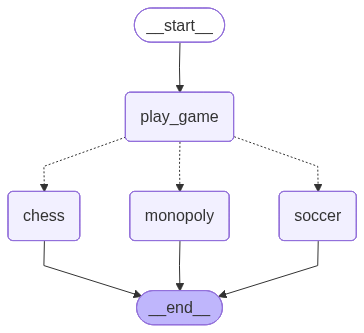

In [52]:
graph_builder

In [58]:
#No error with correct inputs
graph_builder.invoke(State(name='soham',
                           game='chess'))

play_game node has been called


{'name': 'soham want to play soccer', 'game': 'soccer'}

In [59]:
#Model rightfully throws an error due to validation error
graph_builder.invoke(State(name='soham',
                           game='foosball'))

ValidationError: 1 validation error for State
game
  Input should be 'chess', 'monopoly' or 'soccer' [type=literal_error, input_value='foosball', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/literal_error